In [164]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [165]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [166]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
from keras.models import Model

In [167]:
np.random.seed(0)

In [168]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)


X_train,y_train = train_data['features'],train_data['labels']
X_val,y_val = val_data['features'],val_data['labels']
X_test,y_test = test_data['features'],test_data['labels']

In [169]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [170]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [171]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

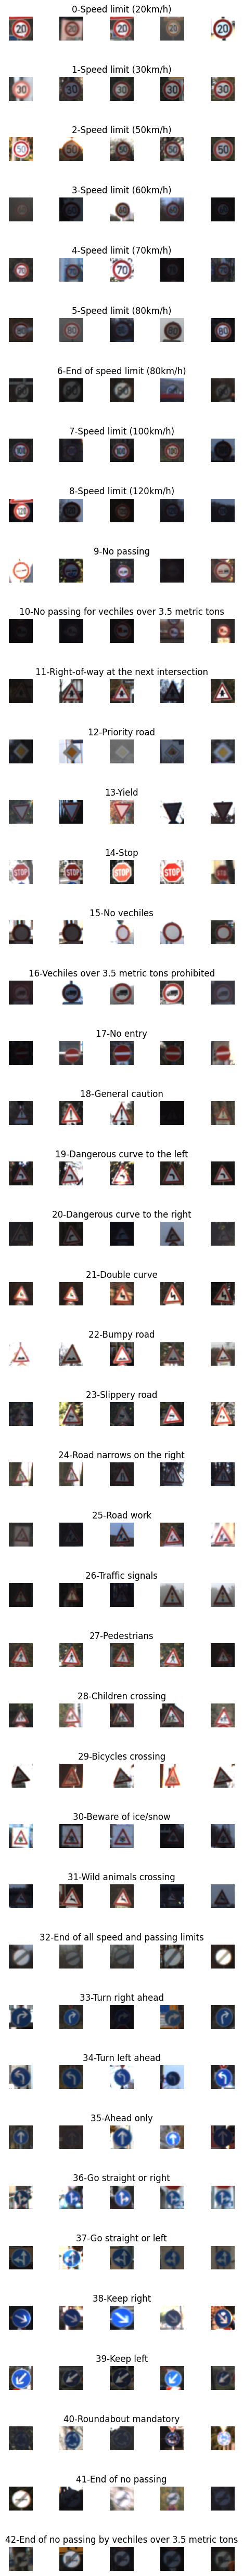

In [174]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+"-"+row["SignName"])
            num_of_samples.append(len(x_selected))




[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

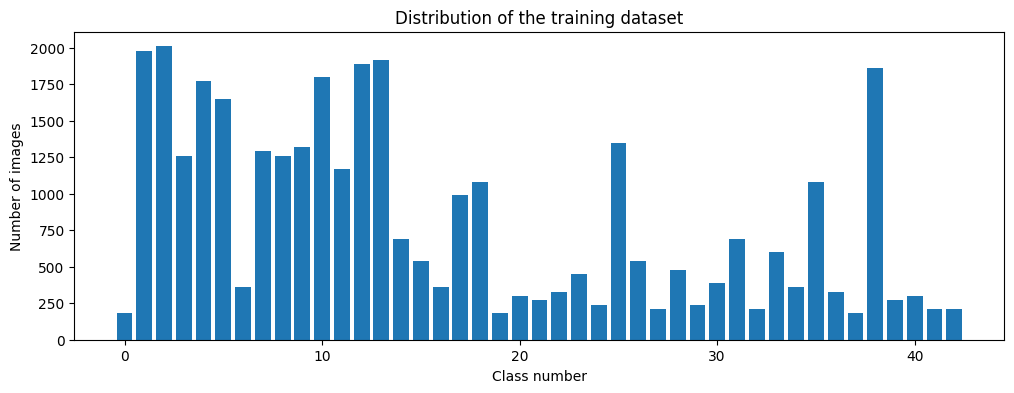

In [175]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


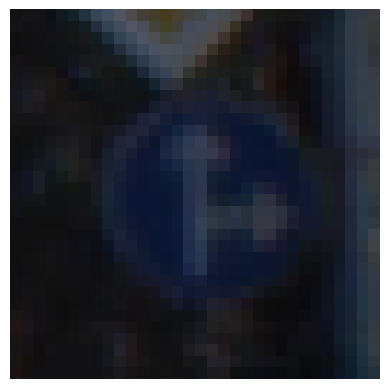

In [176]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


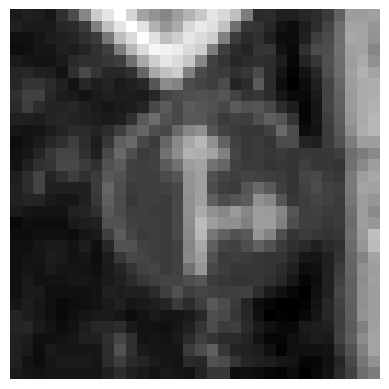

In [177]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img;


grayscaled = grayscale(X_train[1000])
plt.imshow(grayscaled, cmap="gray")
plt.axis("off")
print(grayscaled.shape)

(32, 32)


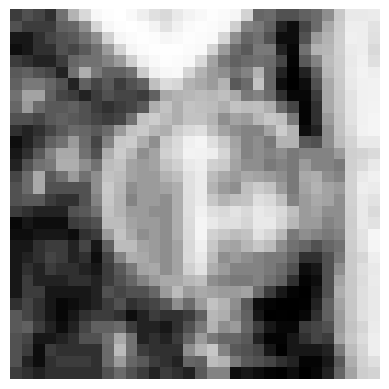

In [178]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img;


img = equalize(grayscaled)
plt.imshow(img, cmap="gray")
plt.axis("off")
print(img.shape)

In [179]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img;

X_train = np.array(list(map(preprocess, X_train)))
X_val =np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))


(34799, 32, 32)


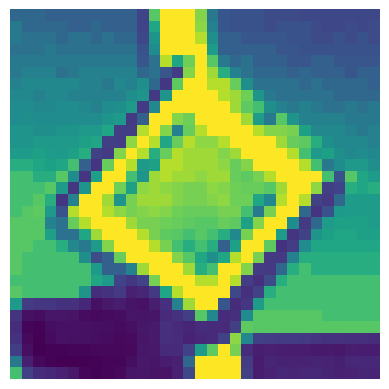

In [180]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [181]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [182]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen =ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)
datagen.fit(X_train)

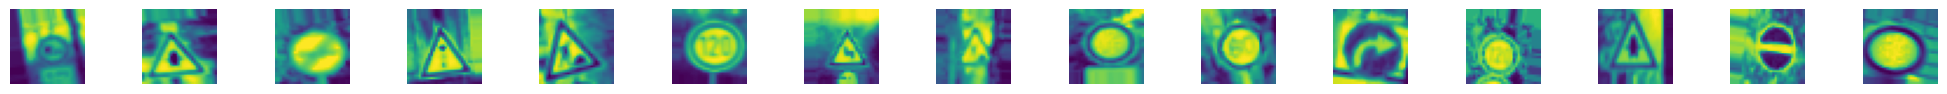

In [183]:
batches = datagen.flow(X_train, y_train,batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32,32))
    axs[i].axis("off")

In [184]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [185]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [186]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [187]:
model = modified_model()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [188]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50) , steps_per_epoch=2000,epochs=10 , validation_data=(X_val, y_val) , shuffle=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 693/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.2869 - loss: 2.6171

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4207 - loss: 2.0733 - val_accuracy: 0.8834 - val_loss: 0.3554
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7961 - loss: 0.6630 - val_accuracy: 0.9608 - val_loss: 0.1358
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8775 - loss: 0.3966 - val_accuracy: 0.9732 - val_loss: 0.0907
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9075 - loss: 0.2960 - val_accuracy: 0.9599 - val_loss: 0.1276
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9240 - loss: 0.2435 - val_accuracy: 0.9828 - val_loss: 0.0622
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9344 - loss: 0.2096 - val_accuracy: 0.9785 - val_loss: 0.0689
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9455 - loss: 0.1773 - val_accuracy: 0.9857 - val_loss: 0.0493
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9503 - loss: 0.1610 - val

Text(0.5, 0, 'epoch')

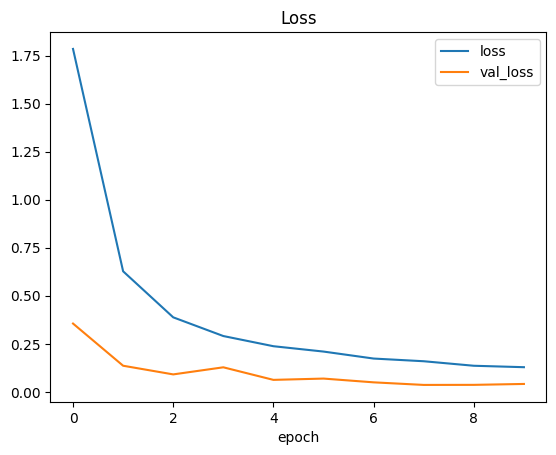

In [196]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

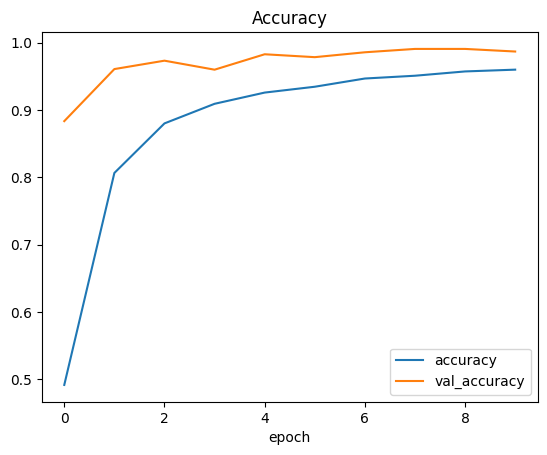

In [190]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [191]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test score:', score[0])
print('Test accuracy:', score[1])

<class 'list'>
Test score: 0.10820574313402176
Test accuracy: 0.9652414917945862


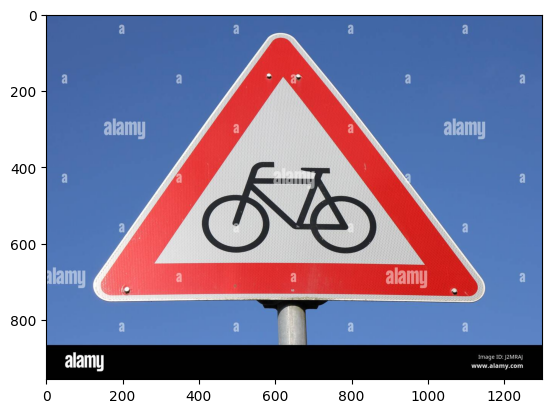

In [214]:
import requests
from PIL import Image
url1 = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url2 = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url3 = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
url4 = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
url5 = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url5, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


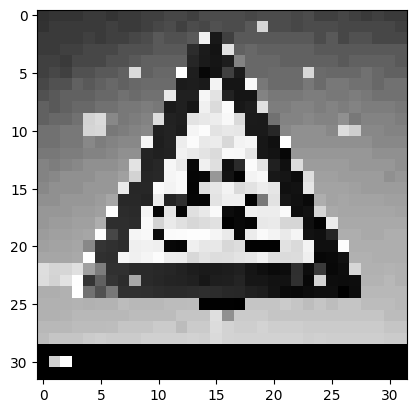

In [215]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [216]:
img = img.reshape(1, 32, 32, 1)

In [217]:
prediction = np.argmax(model.predict(img), axis=-1)
print("predicted sign:", str(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted sign: [29]
